# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [99]:
# Import libraries
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, \
                                  avg, from_unixtime, split, min, max, round, lit, mean
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

#from pyspark.sql.types import IntegerType, TimestampType
import datetime
from pyspark.sql.functions import to_date, year, month, dayofmonth, dayofweek, hour, date_format, substring

import numpy as np
import pandas as pd
import time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

In [100]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [4]:
# Set time parser policy
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

### Common Functions

In [5]:
# Set plot's figure size
def set_plot_size(width, height):
    return plt.figure(figsize = [width, height]);

def get_user_logs(userId, sessionId=None):
    if sessionId == None:
        return data.where(data.userId == userId) \
            .select('tsDate', 'userId', 'sessionId', 'itemInSession', 'level', 'page') \
            .sort('tsDate', 'itemInSession')
    else:
        return data.where((data.userId == userId) & (data.sessionId == sessionId)) \
            .select('tsDate', 'userId', 'sessionId', 'itemInSession', 'level', 'page') \
            .sort('tsDate', 'itemInSession')
    
def get_users(churn):
    return data.where(data.churn == churn).select('userId').dropDuplicates()

# Load and prepare Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [7]:
# Load dataset
path = "data/mini_sparkify_event_data.json"
data = spark.read.json(path)
original_count = data.count()

In [8]:
# Remove rows with missing users
data = data.where(~((col('userId').isNull()) | (col('userId') == '')))

# Exclude non-relevant columns
data = data.drop('firstName')
data = data.drop('lastName')

data = data.withColumn('regDate', (col('registration') / 1000.0).cast(TimestampType()))
data = data.withColumn('tsDate', (col('ts') / 1000.0).cast(TimestampType()))
data.take(1)

data = data.withColumn('city', split(data['location'], ',')[0])
data = data.withColumn('state', split(data['location'], ',')[1])
data = data.drop('location')

# Define churned users using Cancellation Confirmation event (canceled)
query_churn_by_cc = data.where(data.page == 'Cancellation Confirmation')
print(f'Churned users who cancelled subscription: {query_churn_by_cc.count()}')

# Label churned (canceled) users
canceled = query_churn_by_cc.select('userId').dropDuplicates().select('userId')
canceled_uids = [row.userId for row in canceled.collect()];
set_churn = udf(lambda x: 1 if x in canceled_uids else 0, IntegerType())
data = data.withColumn('churn', set_churn('userId'))

# Add [userRowId] column that assigns a 1-based index to every user's log ordered by [ts]
w =  Window.partitionBy(data.userId).orderBy('ts', 'itemInSession')
data = data.withColumn('userRowId', row_number().over(w))

# Add [userRowDescId] column that assigns a 1-based index to every user's log ordered by [ts] descending.
w =  Window.partitionBy(data.userId).orderBy(col('ts').desc(), col('itemInSession').desc())
data = data.withColumn('userRowDescId', row_number().over(w))

# Add last level column
last_levels = dict()
for row in data.where(data.userRowDescId == 1).select('userId', 'level').collect():
    last_levels[row.userId] = row.level
get_level = udf(lambda userId: last_levels[userId])
data = data.withColumn('lastLevel', get_level('userId'))

Churned users who cancelled subscription: 52


In [36]:
# Add date column
data = data.withColumn('date', date_format(col('tsDate'), 'yyyy-MM-dd').alias('date').cast('date'))
data.take(1)

[Row(artist=None, auth='Logged In', gender='F', itemInSession=34, length=None, level='free', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', regDate=datetime.datetime(2018, 9, 27, 4, 45, 40), tsDate=datetime.datetime(2018, 11, 21, 19, 12, 32), city='Bridgeport-Stamford-Norwalk', state=' CT', churn=0, userRowId=381, userRowDescId=1, lastLevel='free', date=datetime.date(2018, 11, 21))]

In [9]:
get_users(1).count()

52

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [50]:
data_labels = data.select(col('churn').alias('label'), 'userId').dropDuplicates()

### User Attribute Features

In [10]:
f_Gender = data \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int').alias('Gender'))

In [11]:
f_LastLevel = data \
    .select('userId', 'lastLevel') \
    .dropDuplicates() \
    .replace(['free', 'paid'], ['0', '1'], 'lastLevel') \
    .select('userId', col('lastLevel').cast('int').alias('LastLevel'))

### Per Log Features

In [12]:
def page_count(page):
    return data \
        .where(data.page == page) \
        .groupby('userId') \
        .agg(count('userId').alias('count')) \
        .select('userId', col('count').alias(page.replace(' ', '') + 'Count'))

In [13]:
f_LogCount = data \
    .groupby('userId') \
    .agg(count('userId').alias('LogCount'))

In [14]:
f_SongCount = data \
    .where(data.page == 'NextSong') \
    .groupby('userId') \
    .agg(count('userId').alias('SongCount'))

In [15]:
f_NonSongCount = data \
    .where(data.page != 'NextSong') \
    .groupby('userId') \
    .agg(count('userId').alias('NonSongCount'))

In [16]:
f_AboutCount = page_count('About')

In [17]:
f_ThumbsUpCount = page_count('Thumbs Up')

In [18]:
f_RollAdvertCount = page_count('Roll Advert')

### Per Session Features

In [19]:
page_data = data.where(~data.page.isin(['Cancel', 'Cancellation Confirmation'])) \
    .select('page', 'userId', 'sessionId', 'ts')

In [20]:
# Average page count per session hour
session_hours = page_data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000/3600).alias('sessionHours'))

def page_session_hour(page):
    return page_data \
        .where(data.page == page) \
        .join(session_hours, ['userId', 'sessionId'], 'inner') \
        .groupby( 'userId', 'sessionId', 'sessionHours') \
        .agg((count('userId')/col('sessionHours')).alias('avgPerSession')) \
        .groupby('userId') \
        .agg(avg('avgPerSession').alias('avg')) \
        .select('userId', col('avg').alias(page.replace(' ', '') + 'PerSessionHour'))

In [21]:
# Average page count per hour
user_hours = page_data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000/3600).alias('sessionHours')) \
    .groupby('userId') \
    .agg(Fsum('sessionHours').alias('hours'))

def page_hour(page):
    return page_data \
        .where(data.page == page) \
        .join(user_hours, 'userId', 'inner') \
        .groupby('userId', 'hours') \
        .agg((count('userId')/col('hours')).alias('avg')) \
        .select('userId', col('avg').alias(page.replace(' ', '') + 'PerHour'))

In [22]:
f_SessionCount = data \
    .select('userId', 'sessionId') \
    .dropDuplicates() \
    .groupby('userId') \
    .agg(count('userId').alias('SessionCount'))

In [23]:
f_AvgSessionLength = data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000).alias('sessionLength')) \
    .groupby('userId') \
    .agg(avg('sessionLength').alias('AvgSessionLength')) \

In [24]:
# Session gap
users = data.select('userId').dropDuplicates()

f_AvgSessionGap = data \
    .groupby('userId', 'sessionId') \
    .agg(min('ts').alias('startTime'), max('ts').alias('endTime')) \
    .groupby('userId') \
    .agg(count('userId').alias('sessionCount'), \
        ((max('endTime') - min('startTime'))/1000).alias('observationPeriodTime'), \
        (Fsum(col('endTime') - col('startTime'))/1000).alias('totalSessionTime')) \
    .where(col('sessionCount') > 1) \
    .join(users, 'userId', 'outer') \
    .fillna(0) \
    .select('userId', \
            (col('observationPeriodTime') - col('totalSessionTime')/(col('sessionCount') - 1)).alias('AvgSessionGap'))

In [25]:
f_DowngradePerSessionHour = page_session_hour('Downgrade')

In [26]:
f_ErrorPerSessionHour = page_session_hour('Error')

In [27]:
f_SettingsPerSessionHour = page_session_hour('Settings')

In [28]:
f_SaveSettingsPerSessionHour = page_session_hour('Save Settings')

In [29]:
f_LogoutPerSessionHour = page_session_hour('Logout')

In [30]:
f_SubmitDowngradePerSessionHour = page_session_hour('Submit Downgrade')

### Per Hour Features

In [31]:
f_RollAdvertPerHour = page_hour('Roll Advert')

In [32]:
f_ThumbsDownPerHour = page_hour('Thumbs Down')

In [33]:
f_UpgradePerHour = page_hour('Upgrade')

In [34]:
f_SubmitUpgradePerHour = page_hour('Submit Upgrade')

### Per Day Features

In [37]:
# Average page count per day
page_data = data \
    .where(~data.page.isin(['Cancel', 'Cancellation Confirmation'])) \
    .select('userId', 'page', 'date')

def page_day(page):
    return page_data \
        .where(data.page == page) \
        .groupby('userId', 'date') \
        .count() \
        .groupby('userId') \
        .agg(avg('count').alias(page.replace(' ', '') + 'PerDay'))

In [38]:
# Average sessions per day
f_SessionsPerDay = data \
    .select('userId', 'date', 'sessionId') \
    .dropDuplicates() \
    .groupby('userId', 'date') \
    .count() \
    .groupby('userId') \
    .agg(avg('count').alias('SessionsPerDay'))

In [39]:
f_AddFriendPerDay = page_day('Add Friend')

In [40]:
f_RollAdvertPerDay = page_day('Roll Advert')

In [41]:
f_ThumbsDownPerDay = page_day('Thumbs Down')

In [42]:
f_ThumbsUpPerDay = page_day('Thumbs Up')

### Per Song Features

In [43]:
# Total song length 
f_TotalSongLength = data \
    .where(data.page == 'NextSong') \
    .select('userId', 'length') \
    .groupby('userId') \
    .agg(Fsum('length').alias('TotalSongLength'))

In [44]:
# Unique song count
f_UniqueSongCount = data \
    .where(data.page == 'NextSong') \
    .select('userId', 'song') \
    .dropDuplicates() \
    .groupby('userId') \
    .agg(count('userId').alias('UniqueSongCount'))

In [45]:
# Share of unique songs among all user's songs
totals = data \
    .where(data.page == 'NextSong') \
    .select('userId') \
    .groupby('userId') \
    .agg(count('userId').alias('total'))

f_UniqueSongShare = data \
    .where(data.page == 'NextSong') \
    .select('userId', 'song') \
    .dropDuplicates() \
    .groupby('userId') \
    .count() \
    .join(totals, on = ['userId'], how = 'inner') \
    .select('userId', (col('count')/col('total')).alias('UniqueSongShare')) 

### model_data

In [148]:
# model 7b (churn #1, seed 0)
model_data  = labels.join(f_LogCount, 'userId', 'outer') \
    .join(f_SongCount, 'userId', 'outer') \
    .join(f_NonSongCount, 'userId', 'outer') \
    .join(f_AboutCount, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_AvgSessionLength, 'userId', 'outer') \
    .join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_DowngradePerSessionHour, 'userId', 'outer') \
    .join(f_SettingsPerSessionHour, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_SubmitUpgradePerHour, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_AddFriendPerDay, 'userId', 'outer') \
    .join(f_RollAdvertPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .join(f_ThumbsUpPerDay, 'userId', 'outer') \
    .join(f_TotalSongLength, 'userId', 'outer') \
    .join(f_UniqueSongCount, 'userId', 'outer') \
    .join(f_UniqueSongShare, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [161]:
# model 7 (churn #1, seed 0)
model_data_rf  = labels.join(f_Gender, 'userId', 'outer') \
    .join(f_LastLevel, 'userId', 'outer') \
    .join(f_LogCount, 'userId', 'outer') \
    .join(f_SongCount, 'userId', 'outer') \
    .join(f_NonSongCount, 'userId', 'outer') \
    .join(f_AboutCount, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_AvgSessionLength, 'userId', 'outer') \
    .join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_DowngradePerSessionHour, 'userId', 'outer') \
    .join(f_ErrorPerSessionHour, 'userId', 'outer') \
    .join(f_SettingsPerSessionHour, 'userId', 'outer') \
    .join(f_SaveSettingsPerSessionHour, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_SubmitDowngradePerSessionHour, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_UpgradePerHour, 'userId', 'outer') \
    .join(f_SubmitUpgradePerHour, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_AddFriendPerDay, 'userId', 'outer') \
    .join(f_RollAdvertPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .join(f_ThumbsUpPerDay, 'userId', 'outer') \
    .join(f_TotalSongLength, 'userId', 'outer') \
    .join(f_UniqueSongCount, 'userId', 'outer') \
    .join(f_UniqueSongShare, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [177]:
# model 6
model_data  = labels.join(f_EventCount, 'userId', 'outer') \
    .join(f_AvgSessionCount, 'userId', 'outer') \
    .join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_RollAdvertCountPerHour, 'userId', 'outer') \
    .join(f_ThumbsDownCountPerHour, 'userId', 'outer') \
    .join(f_SettingsCountPerHour, 'userId', 'outer') \
    .join(f_LogoutCountPerHour, 'userId', 'outer') \
    .join(f_SaveSettingsCountPerHour, 'userId', 'outer') \
    .join(f_TotalSongLength, 'userId', 'outer') \
    .join(f_AvgNonSongEventCount, 'userId', 'outer') \
    .join(f_UniqueSongCount, 'userId', 'outer') \
    .join(f_UniqueSongShare, 'userId', 'outer') \
    .join(f_AvgGapTime, 'userId', 'outer') \
    .join(f_ThumbsDownCountPerDay, 'userId', 'outer') \
    .join(f_ThumbsUpCountPerDay, 'userId', 'outer') \
    .join(f_AvgSessionCountPerDay, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [148]:
# model 5
model_data  = labels.join(f_EventCount, 'userId', 'outer') \
    .join(f_AvgSessionCount, 'userId', 'outer') \
    .join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_SubmitUpgradeCount, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_RollAdvertCountPerHour, 'userId', 'outer') \
    .join(f_SubmitUpgradeCountPerHour, 'userId', 'outer') \
    .join(f_ThumbsDownCountPerHour, 'userId', 'outer') \
    .join(f_UpgradeCountPerHour, 'userId', 'outer') \
    .join(f_SettingsCountPerHour, 'userId', 'outer') \
    .join(f_LogoutCountPerHour, 'userId', 'outer') \
    .join(f_SaveSettingsCountPerHour, 'userId', 'outer') \
    .join(f_TotalSongLength, 'userId', 'outer') \
    .join(f_AvgNonSongEventCount, 'userId', 'outer') \
    .join(f_UniqueSongCount, 'userId', 'outer') \
    .join(f_UniqueSongShare, 'userId', 'outer') \
    .join(f_AvgGapTime, 'userId', 'outer') \
    .join(f_ThumbsDownCountPerDay, 'userId', 'outer') \
    .join(f_ThumbsUpCountPerDay, 'userId', 'outer') \
    .join(f_UpgradeCountPerDay, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [ ]:
# model 4
model_data  = labels.join(f_EventCount, 'userId', 'outer') \
    .join(f_AvgSessionCount, 'userId', 'outer') \
    .join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_SubmitUpgradeCount, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_RollAdvertCountPerHour, 'userId', 'outer') \
    .join(f_SubmitUpgradeCountPerHour, 'userId', 'outer') \
    .join(f_ThumbsDownCountPerHour, 'userId', 'outer') \
    .join(f_UpgradeCountPerHour, 'userId', 'outer') \
    .join(f_SettingsCountPerHour, 'userId', 'outer') \
    .join(f_LogoutCountPerHour, 'userId', 'outer') \
    .join(f_SaveSettingsCountPerHour, 'userId', 'outer') \
    .join(f_TotalSongLength, 'userId', 'outer') \
    .join(f_AvgNonSongEventCount, 'userId', 'outer') \
    .join(f_UniqueSongCount, 'userId', 'outer') \
    .join(f_UniqueSongShare, 'userId', 'outer') \
    .join(f_AvgGapTime, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [130]:
# model 3
model_data  = labels.join(f_EventCount, 'userId', 'outer') \
    .join(f_AvgSessionCount, 'userId', 'outer') \
    .join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_SubmitUpgradeCount, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_RollAdvertCountPerHour, 'userId', 'outer') \
    .join(f_SubmitUpgradeCountPerHour, 'userId', 'outer') \
    .join(f_ThumbsDownCountPerHour, 'userId', 'outer') \
    .join(f_UpgradeCountPerHour, 'userId', 'outer') \
    .join(f_SettingsCountPerHour, 'userId', 'outer') \
    .join(f_LogoutCountPerHour, 'userId', 'outer') \
    .join(f_SaveSettingsCountPerHour, 'userId', 'outer') \
    .join(f_TotalSongLength, 'userId', 'outer') \
    .join(f_AvgNonSongEventCount, 'userId', 'outer') \
    .join(f_UniqueSongCount, 'userId', 'outer') \
    .join(f_UniqueSongShare, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [46]:
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, \
    NaiveBayes, DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [154]:
def get_features(data):
    return data.drop('label').columns

def split_data(data, seed=0):
    train, test = data.randomSplit([0.8, 0.2], seed=seed);
    return train, test

def create_pipeline(data, classifier, scaler):
    features = get_features(data)
    assembler = VectorAssembler(inputCols=features, outputCol='NumFeatures')
    pipeline = Pipeline(stages=[assembler, scaler, classifier]);

    return pipeline

def fit_model(data, classifier, seed=0):
    
    start_time = time.time()
    
    print('Model fitting started. Please wait...')

    # Split data into train and test subset
    train, test = split_data(data, seed)
    print('Train|Test data split done.')

    # Create pipeline
    scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
    pipeline = create_pipeline(data, classifier, scaler)
    print('Create pipeline done.')

    # train model
    model = pipeline.fit(train)
    print('Training done.')

    # get metrics
    metrics = calc_metrics(model, test)
    print('Metrics prepared.')

    fitting_duration = time.time() - start_time
    
    print(f'Model fitting done ({int(fitting_duration)} s).')
    
    return model, metrics


In [48]:
# source: https://stackoverflow.com/questions/60772315/how-to-evaluate-a-classifier-with-apache-spark-2-4-5-and-pyspark-python
def calc_metrics(model, test):

    # Create both evaluators
    evaluatorMulti = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')
    evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')

    # Make predicitons
    prediction = model.transform(test).select('label', 'prediction')

    # Get metrics
    acc = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: 'accuracy'})
    f1 = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: 'f1'})
    weightedPrecision = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: 'weightedPrecision'})
    weightedRecall = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: 'weightedRecall'})
    auc = evaluator.evaluate(prediction)
    
    metrics = pd.DataFrame(index=['F1', 'accuracy', 'weighted precision', 'weighted recall', 'AUC'], \
                           data={'metrics value': [f1, acc, weightedPrecision, weightedRecall, auc]})
    
    return metrics
    

In [118]:
# Plot feature importances
def plot_feature_importance(data, model, height, title):
    features = get_features(data)
    feature_coeff = model.stages[-1].featureImportances
    feature_importances = pd.DataFrame(list(zip(features, feature_coeff)), \
                                       columns=['Feature', 'FeatureImportances']) \
        .sort_values('FeatureImportances', ascending=False)

    values = feature_importances.sort_values(by='FeatureImportances', ascending=False)['FeatureImportances']
    labels = feature_importances.sort_values(by='FeatureImportances', ascending=False)['Feature']

    plt.figure(figsize = [8, height])
    plt.barh(np.arange(len(values)), values, height=0.6)
    ax = plt.gca()
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('FeatureImportances')
    ax.set_ylabel('Features')
    ax.set_title(title)
    plt.grid(True, axis='x', linewidth= 1, linestyle="--")

    plt.show()

## Logistic Regression

In [360]:
feature_importances_rfc

,Feature,FeatureImportances
10,AvgSessionGap,0.213280
21,SessionsPerDay,0.071358
18,ThumbsDownPerHour,0.061838
17,RollAdvertPerHour,0.057433
8,SessionCount,0.042105
15,LogoutPerSessionHour,0.041166
23,RollAdvertPerDay,0.040237
24,ThumbsDownPerDay,0.037549
7,RollAdvertCount,0.034767
22,AddFriendPerDay,0.034394


### LR #1

In [363]:
# Best features chosen for Logistic Regression
data_lr = data_labels.join(f_LogCount, 'userId', 'outer') \
    .join(f_SongCount, 'userId', 'outer') \
    .join(f_NonSongCount, 'userId', 'outer') \
    .join(f_AboutCount, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_AvgSessionLength, 'userId', 'outer') \
    .join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_SettingsPerSessionHour, 'userId', 'outer') \
    .join(f_SaveSettingsPerSessionHour, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_UpgradePerHour, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_AddFriendPerDay, 'userId', 'outer') \
    .join(f_RollAdvertPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .join(f_ThumbsUpPerDay, 'userId', 'outer') \
    .join(f_TotalSongLength, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [367]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features")
classifier = LogisticRegression(featuresCol="features", labelCol = "label")
model_lr, metrics_lr = fit_model(data_lr, classifier, scaler)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.


Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "C:\Users\Amos\Anaconda2\lib\site-packages\pyspark\ml\wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'LogisticRegression' object has no attribute '_java_obj'


Training done.
Metrics prepared.
Model fitting done (950 s).


In [368]:
metrics_lr

,metrics value
F1,0.834824
accuracy,0.820000
weighted precision,0.855610
weighted recall,0.820000
AUC,0.681818


### LR #2

In [369]:
# Best features chosen for Logistic Regression
data_lr = data_labels.join(f_LogCount, 'userId', 'outer') \
    .join(f_SongCount, 'userId', 'outer') \
    .join(f_NonSongCount, 'userId', 'outer') \
    .join(f_AboutCount, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_AvgSessionLength, 'userId', 'outer') \
    .join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_DowngradePerSessionHour, 'userId', 'outer') \
    .join(f_SettingsPerSessionHour, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_SubmitUpgradePerHour, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_AddFriendPerDay, 'userId', 'outer') \
    .join(f_RollAdvertPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .join(f_ThumbsUpPerDay, 'userId', 'outer') \
    .join(f_TotalSongLength, 'userId', 'outer') \
    .join(f_UniqueSongCount, 'userId', 'outer') \
    .join(f_UniqueSongShare, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [370]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features")
classifier = LogisticRegression(featuresCol="features", labelCol = "label")
model_lr, metrics_lr = fit_model(data_lr, classifier, scaler)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (1180 s).


In [371]:
metrics_lr

,metrics value
F1,0.849568
accuracy,0.840000
weighted precision,0.862143
weighted recall,0.840000
AUC,0.693182


### LR #3

In [375]:
# Best features chosen for Logistic Regression
data_lr = data_labels.join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_RollAdvertPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_AddFriendPerDay, 'userId', 'outer') \
    .join(f_ThumbsUpPerDay, 'userId', 'outer') \
    .join(f_SaveSettingsPerSessionHour, 'userId', 'outer') \
    .join(f_SettingsPerSessionHour, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [376]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features")
classifier = LogisticRegression(featuresCol="features", labelCol = "label")
model_lr, metrics_lr = fit_model(data_lr, classifier, scaler)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (678 s).


In [377]:
metrics_lr

,metrics value
F1,0.849568
accuracy,0.840000
weighted precision,0.862143
weighted recall,0.840000
AUC,0.693182


### LR #4

In [379]:
# Best features chosen for Logistic Regression
data_lr = data_labels.join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_RollAdvertPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [381]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features")
classifier = LogisticRegression(featuresCol="features", labelCol = "label")
model_lr, metrics_lr = fit_model(data_lr, classifier, scaler)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (468 s).


In [382]:
metrics_lr

,metrics value
F1,0.856190
accuracy,0.840000
weighted precision,0.884000
weighted recall,0.840000
AUC,0.765152


### Cross-Validation

In [390]:
data_lr.printSchema()

root
 |-- label: integer (nullable = true)
 |-- AvgSessionGap: double (nullable = false)
 |-- SessionsPerDay: double (nullable = false)
 |-- ThumbsDownPerHour: double (nullable = false)
 |-- RollAdvertPerHour: double (nullable = false)
 |-- SessionCount: long (nullable = true)
 |-- LogoutPerSessionHour: double (nullable = false)
 |-- RollAdvertPerDay: double (nullable = false)
 |-- ThumbsDownPerDay: double (nullable = false)



In [385]:
print('Cross validation started. Please wait...')

# Create classifier
lr = LogisticRegression(featuresCol='features', labelCol = 'label')

# Create pipeline
scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
pipeline = create_pipeline(data_lr, lr, scaler)

# Define params
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 20]) \
    .addGrid(lr.regParam, [0.0, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
    .build()

# Create cross validator
crossval_lr = CrossValidator(estimator = pipeline,
                             estimatorParamMaps = paramGrid_lr,
                             evaluator = MulticlassClassificationEvaluator(),
                             numFolds = 2)

# Fit model
start_time = time.time()
crossval_model_lr = crossval_lr.fit(train)
duration = time.time() - start_time

print(f'Cross validation done ({int(duration)} s).')

# Show best params
print('\nCross validation parameters ordered by score, descending:')
scores = crossval_model_lr.avgMetrics
params = [{p.name: v for p, v in m.items()} for m in crossval_model_lr.getEstimatorParamMaps()]
params_df = pd.DataFrame(params)
params_df['score'] = scores
params_df.sort_values(by='score', ascending=False)

Cross validation started. Please wait...
Cross validation done (1810 s).

Cross validation parameters ordered by score, descending:


,elasticNetParam,maxIter,regParam,score
2,0.0,10,0.1,0.807631
6,0.0,20,0.1,0.794845
4,0.0,20,0.0,0.794637
5,0.5,20,0.0,0.794637
0,0.0,10,0.0,0.793251
1,0.5,10,0.0,0.793251
3,0.5,10,0.1,0.772826
7,0.5,20,0.1,0.770787


### Best model

In [386]:
scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
classifier = LogisticRegression(featuresCol='features', labelCol='label', \
                                elasticNetParam=0.0, maxIter=10, regParam=0.1)
model_lr_cvbest, metrics_lr = fit_model(data_lr, classifier, scaler)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (502 s).


#### Result

In [387]:
metrics_lr

,metrics value
F1,0.896016
accuracy,0.900000
weighted precision,0.893333
weighted recall,0.900000
AUC,0.727273


### Summary

## Random Forest

In [364]:
# Best features chosen for Random Forest classifier
data_rfc = data_labels.join(f_Gender, 'userId', 'outer') \
    .join(f_LastLevel, 'userId', 'outer') \
    .join(f_LogCount, 'userId', 'outer') \
    .join(f_SongCount, 'userId', 'outer') \
    .join(f_NonSongCount, 'userId', 'outer') \
    .join(f_AboutCount, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_AvgSessionLength, 'userId', 'outer') \
    .join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_DowngradePerSessionHour, 'userId', 'outer') \
    .join(f_ErrorPerSessionHour, 'userId', 'outer') \
    .join(f_SettingsPerSessionHour, 'userId', 'outer') \
    .join(f_SaveSettingsPerSessionHour, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_SubmitDowngradePerSessionHour, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_UpgradePerHour, 'userId', 'outer') \
    .join(f_SubmitUpgradePerHour, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_AddFriendPerDay, 'userId', 'outer') \
    .join(f_RollAdvertPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .join(f_ThumbsUpPerDay, 'userId', 'outer') \
    .join(f_TotalSongLength, 'userId', 'outer') \
    .join(f_UniqueSongCount, 'userId', 'outer') \
    .join(f_UniqueSongShare, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

### Cross-Validation

In [294]:
print('Cross validation started. Please wait...')

# Create classifier
rfc = RandomForestClassifier(seed=0)

# Create pipeline
scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
pipeline = create_pipeline(data_rfc, rfc, scaler)

# Define params
paramGrid_rfc = ParamGridBuilder() \
    .addGrid(rfc.maxDepth, [4, 5, 6]) \
    .addGrid(rfc.numTrees, [10, 20, 50]) \
    .build()

# Create cross validator
crossval_rfc = CrossValidator(estimator = pipeline,
                              estimatorParamMaps = paramGrid_rfc,
                              evaluator = MulticlassClassificationEvaluator(),
                              numFolds = 2)

# Fit model
start_time = time.time()
crossval_model_rfc = crossval_rfc.fit(train)
duration = time.time() - start_time

print(f'Cross validation done ({int(duration)} s).')

# Show best params
print('\nCross validation parameters ordered by score, descending:')
scores = crossval_model_rfc.avgMetrics
params = [{p.name: v for p, v in m.items()} for m in crossval_model_rfc.getEstimatorParamMaps()]
params_df = pd.DataFrame(params)
params_df['score'] = scores
params_df.sort_values(by='score', ascending=False)

Cross validation started. Please wait...
Cross validation done (1739 s).

Cross validation parameters ordered by score, descending:


,maxDepth,numTrees,score
7,6,20,0.759634
2,4,50,0.758248
8,6,50,0.756516
3,5,10,0.754577
4,5,20,0.752732
5,5,50,0.748812
6,6,10,0.745256
0,4,10,0.725191
1,4,20,0.722808


### Best model

In [357]:
scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
classifier = RandomForestClassifier(seed=0, maxDepth=6, numTrees=20)
model_rfc_cvbest, metrics_rfc = fit_model(data_rfc, classifier, scaler)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (1456 s).


#### Result

In [356]:
# Show metrics
metrics_rfc

,metrics value
F1,0.912889
accuracy,0.920000
weighted precision,0.912609
weighted recall,0.920000
AUC,0.738636


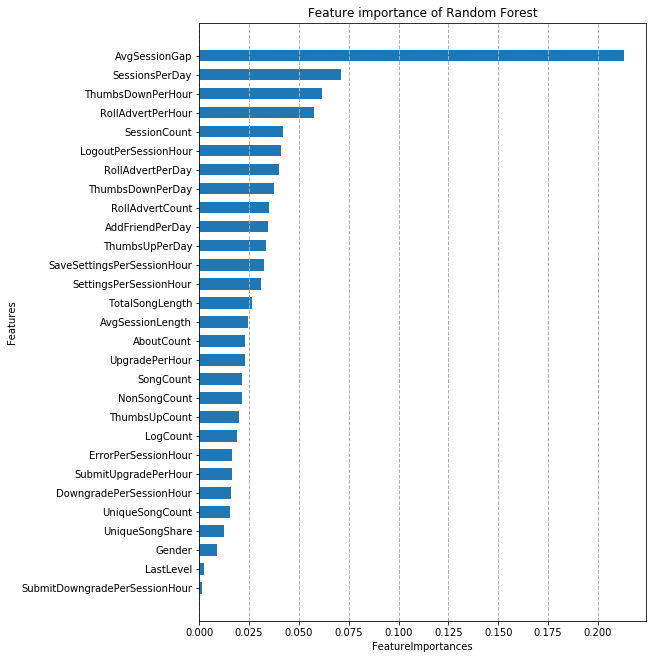

In [336]:
# Plot feature importances
feature_coeff_rfc = model_rfc_cvbest.stages[-1].featureImportances
feature_importances_rfc = pd.DataFrame(list(zip(features, feature_coeff_rfc)), columns=['Feature', 'FeatureImportances']) \
    .sort_values('FeatureImportances', ascending=False)

values = feature_importances_rfc.sort_values(by='FeatureImportances', ascending=False)['FeatureImportances']
labels = feature_importances_rfc.sort_values(by='FeatureImportances', ascending=False)['Feature']

plt.figure(figsize = [8, 11])
plt.barh(np.arange(len(values)), values, height=0.6)
ax = plt.gca()
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('FeatureImportances')
ax.set_ylabel('Features')
ax.set_title('Feature importance of Random Forest')
plt.grid(True, axis='x', linewidth= 1, linestyle="--")

plt.show()

### Summary

### GBT Classifier

In [51]:
# Best features chosen for Random Forest classifier
data_gbt = data_labels.join(f_Gender, 'userId', 'outer') \
    .join(f_LastLevel, 'userId', 'outer') \
    .join(f_LogCount, 'userId', 'outer') \
    .join(f_SongCount, 'userId', 'outer') \
    .join(f_NonSongCount, 'userId', 'outer') \
    .join(f_AboutCount, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_AvgSessionLength, 'userId', 'outer') \
    .join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_DowngradePerSessionHour, 'userId', 'outer') \
    .join(f_ErrorPerSessionHour, 'userId', 'outer') \
    .join(f_SettingsPerSessionHour, 'userId', 'outer') \
    .join(f_SaveSettingsPerSessionHour, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_SubmitDowngradePerSessionHour, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_UpgradePerHour, 'userId', 'outer') \
    .join(f_SubmitUpgradePerHour, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_AddFriendPerDay, 'userId', 'outer') \
    .join(f_RollAdvertPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .join(f_ThumbsUpPerDay, 'userId', 'outer') \
    .join(f_TotalSongLength, 'userId', 'outer') \
    .join(f_UniqueSongCount, 'userId', 'outer') \
    .join(f_UniqueSongShare, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [392]:
scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
classifier = GBTClassifier(featuresCol='features', labelCol = 'label')
model_gbt, metrics_gbt = fit_model(data_gbt, classifier, scaler)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (1645 s).


In [393]:
metrics_gbt

,metrics value
F1,0.856190
accuracy,0.840000
weighted precision,0.884000
weighted recall,0.840000
AUC,0.765152


### Cross-Validation

In [394]:
print('Cross validation started. Please wait...')

# Create classifier
gbt = GBTClassifier(seed=0)

# Create pipeline
scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
pipeline = create_pipeline(data_gbt, gbt, scaler)

# Define params
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 50]) \
    .addGrid(gbt.maxDepth,[2, 5]) \
    .addGrid(gbt.maxBins, [32]) \
    .build()

# Create cross validator
crossval_gbt = CrossValidator(estimator = pipeline,
                              estimatorParamMaps = paramGrid_gbt,
                              evaluator = MulticlassClassificationEvaluator(),
                              numFolds = 2)

# Fit model
start_time = time.time()
crossval_model_gbt = crossval_gbt.fit(train)
duration = time.time() - start_time

print(f'Cross validation done ({int(duration)} s).')

# Show best params
print('\nCross validation parameters ordered by score, descending:')
scores = crossval_model_gbt.avgMetrics
params = [{p.name: v for p, v in m.items()} for m in crossval_model_gbt.getEstimatorParamMaps()]
params_df = pd.DataFrame(params)
params_df['score'] = scores
params_df.sort_values(by='score', ascending=False)

Cross validation started. Please wait...
Cross validation done (3995 s).

Cross validation parameters ordered by score, descending:


,maxBins,maxDepth,maxIter,score
2,32,2,50,0.798642
0,32,2,10,0.770697
1,32,5,10,0.730393
3,32,5,50,0.730393


In [52]:
scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
classifier = GBTClassifier(maxBins=32, maxDepth=2, maxIter=50)
model_gbt, metrics_gbt = fit_model(data_gbt, classifier, scaler)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (1743 s).


In [53]:
metrics_gbt

,metrics value
F1,0.854423
accuracy,0.860000
weighted precision,0.849778
weighted recall,0.860000
AUC,0.632576


In [56]:
model_gbt

PipelineModel_424879656432

In [54]:
# important features
importances = list(model_gbt.featureImportances)
y_pos = np.arange(len(features))
plt.barh(y_pos, importances, align='center')
plt.yticks(y_pos, features)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances')

AttributeError: 'PipelineModel' object has no attribute 'featureImportances'

In [ ]:
model_data2 = model_data.select('label', 'features')
train,validation = model_data2.randomSplit([0.8, 0.2], seed=seed)

# models to train: logistic regression, svm, gradient boosting tree
gbt_tuned = GBTClassifier(maxDepth=5, maxIter=10, seed=seed)
gbt_model = gbt_tuned.fit(train)
results = gbt_model.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

print(evaluator.evaluate(results, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(results, {evaluator.metricName: "f1"}))

# important features
importances = list(gbt_model.featureImportances)
y_pos = np.arange(len(features))
plt.barh(y_pos, importances, align='center')
plt.yticks(y_pos, features)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances')
plt.savefig('GBT feature Importance.png', dpi=72)

In [68]:
gbt = model_gbt.stages[2]

In [70]:
gbt.featureImportances

SparseVector(29, {2: 0.0231, 4: 0.0791, 5: 0.012, 6: 0.0287, 7: 0.0156, 8: 0.0075, 10: 0.231, 11: 0.0784, 12: 0.0007, 13: 0.0333, 14: 0.031, 15: 0.0106, 17: 0.0832, 18: 0.0995, 19: 0.0238, 21: 0.0438, 22: 0.0208, 23: 0.0106, 24: 0.0698, 25: 0.0974})

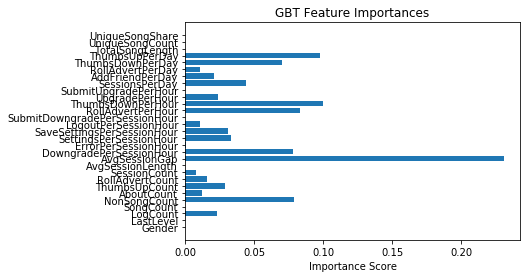

In [72]:
# important features
features = data_gbt.drop('label').columns
importances = list(gbt.featureImportances)
y_pos = np.arange(len(features))
plt.barh(y_pos, importances, align='center')
plt.yticks(y_pos, features)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances')
plt.savefig('GBT feature Importance.png', dpi=72)

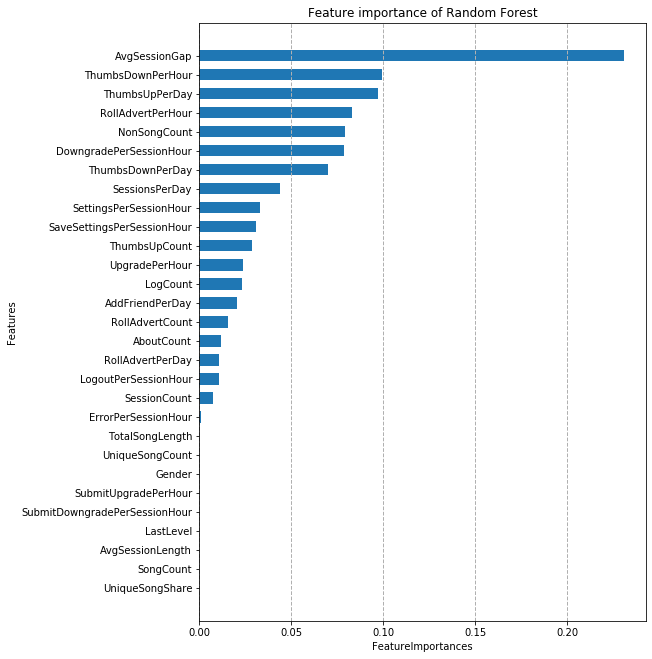

In [74]:
# Plot feature importances
features = data_gbt.drop('label').columns
feature_coeff_rfc = gbt.featureImportances
feature_importances_rfc = pd.DataFrame(list(zip(features, feature_coeff_rfc)), columns=['Feature', 'FeatureImportances']) \
    .sort_values('FeatureImportances', ascending=False)

values = feature_importances_rfc.sort_values(by='FeatureImportances', ascending=False)['FeatureImportances']
labels = feature_importances_rfc.sort_values(by='FeatureImportances', ascending=False)['Feature']

plt.figure(figsize = [8, 11])
plt.barh(np.arange(len(values)), values, height=0.6)
ax = plt.gca()
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('FeatureImportances')
ax.set_ylabel('Features')
ax.set_title('Feature importance of Random Forest')
plt.grid(True, axis='x', linewidth= 1, linestyle="--")

plt.show()

### GBT #2

In [75]:
# Best features chosen for Random Forest classifier
data_gbt = data_labels.join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_ThumbsUpPerDay, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_NonSongCount, 'userId', 'outer') \
    .join(f_DowngradePerSessionHour, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_SettingsPerSessionHour, 'userId', 'outer') \
    .join(f_SaveSettingsPerSessionHour, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [76]:
scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
classifier = GBTClassifier(featuresCol='features', labelCol = 'label')
model_gbt, metrics_gbt = fit_model(data_gbt, classifier, scaler)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (614 s).


In [77]:
metrics_gbt

,metrics value
F1,0.896016
accuracy,0.900000
weighted precision,0.893333
weighted recall,0.900000
AUC,0.727273


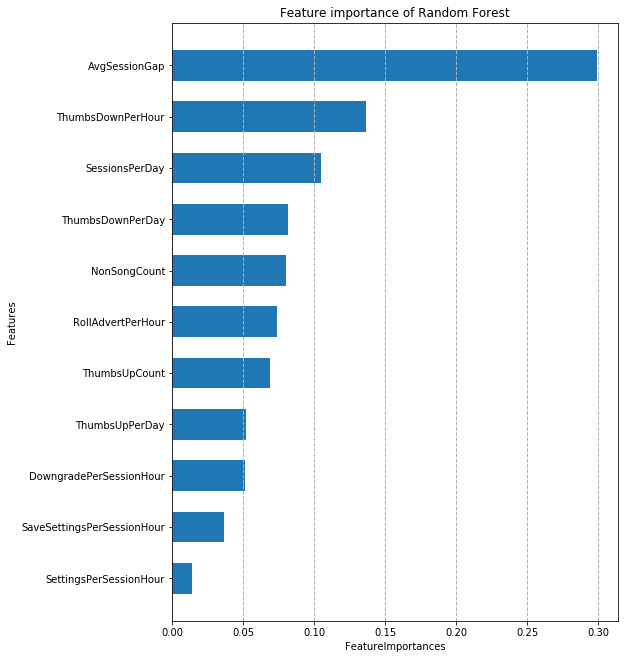

In [78]:
# Plot feature importances
features = data_gbt.drop('label').columns
feature_coeff_rfc = model_gbt.stages[2].featureImportances
feature_importances_rfc = pd.DataFrame(list(zip(features, feature_coeff_rfc)), columns=['Feature', 'FeatureImportances']) \
    .sort_values('FeatureImportances', ascending=False)

values = feature_importances_rfc.sort_values(by='FeatureImportances', ascending=False)['FeatureImportances']
labels = feature_importances_rfc.sort_values(by='FeatureImportances', ascending=False)['Feature']

plt.figure(figsize = [8, 11])
plt.barh(np.arange(len(values)), values, height=0.6)
ax = plt.gca()
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('FeatureImportances')
ax.set_ylabel('Features')
ax.set_title('Feature importance of Random Forest')
plt.grid(True, axis='x', linewidth= 1, linestyle="--")

plt.show()

In [90]:
gbt = model_gbt.stages[2]
print(gbt._java_obj.getMaxIter())
print(gbt._java_obj.getMaxDepth())
print(gbt._java_obj.getMaxBins())

20
5
32


### GBT #3

In [114]:
# Best features chosen for Random Forest classifier
data_gbt = data_labels.join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_ThumbsUpPerDay, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_NonSongCount, 'userId', 'outer') \
    .join(f_DowngradePerSessionHour, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_SettingsPerSessionHour, 'userId', 'outer') \
    .join(f_SaveSettingsPerSessionHour, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_UpgradePerHour, 'userId', 'outer') \
    .join(f_LogCount, 'userId', 'outer') \
    .join(f_AddFriendPerDay, 'userId', 'outer') \
    .join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_AboutCount, 'userId', 'outer') \
    .join(f_RollAdvertPerDay, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [115]:
scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
classifier = GBTClassifier(featuresCol='features', labelCol = 'label')
model_gbt, metrics_gbt = fit_model(data_gbt, classifier, scaler)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (875 s).


In [116]:
metrics_gbt

,metrics value
F1,0.896016
accuracy,0.900000
weighted precision,0.893333
weighted recall,0.900000
AUC,0.727273


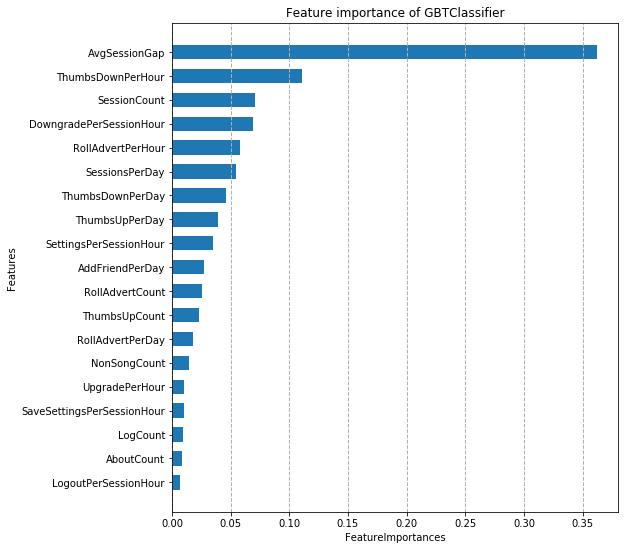

In [119]:
plot_feature_importance(data_gbt, model_gbt, 9, 'Feature importance of GBTClassifier')

### GBT #4 (THE BEST MODEL)

In [120]:
# Best features chosen for Random Forest classifier
data_gbt = data_labels.join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_DowngradePerSessionHour, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [121]:
classifier = GBTClassifier(featuresCol='features', labelCol = 'label')
model_gbt, metrics_gbt = fit_model(data_gbt, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (409 s).


In [122]:
metrics_gbt

,metrics value
F1,0.908235
accuracy,0.900000
weighted precision,0.925203
weighted recall,0.900000
AUC,0.871212


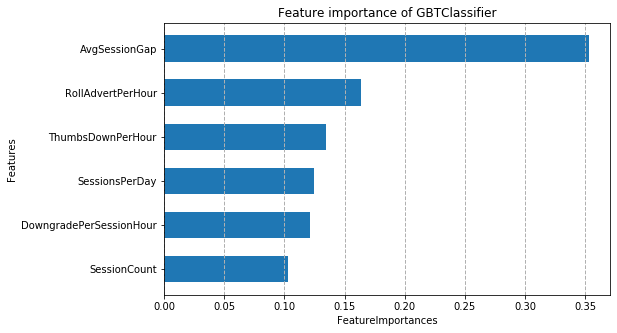

In [125]:
plot_feature_importance(data_gbt, model_gbt, 5, 'Feature importance of GBTClassifier')

##### No difference if we use MinMaxScaler

In [126]:
scaler = MinMaxScaler(inputCol='NumFeatures', outputCol='features')
classifier = GBTClassifier(featuresCol='features', labelCol = 'label')
model_gbt, metrics_gbt = fit_model(data_gbt, classifier, scaler)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (417 s).


In [127]:
metrics_gbt

,metrics value
F1,0.908235
accuracy,0.900000
weighted precision,0.925203
weighted recall,0.900000
AUC,0.871212


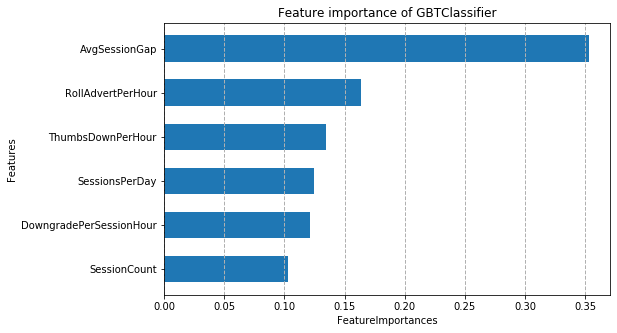

In [128]:
plot_feature_importance(data_gbt, model_gbt, 5, 'Feature importance of GBTClassifier')

### GBT #5

In [129]:
# Best features chosen for Random Forest classifier
data_gbt = data_labels.join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_DowngradePerSessionHour, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [130]:
scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
classifier = GBTClassifier(featuresCol='features', labelCol = 'label')
model_gbt, metrics_gbt = fit_model(data_gbt, classifier, scaler)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (450 s).


In [131]:
metrics_gbt

,metrics value
F1,0.892143
accuracy,0.880000
weighted precision,0.918000
weighted recall,0.880000
AUC,0.859848


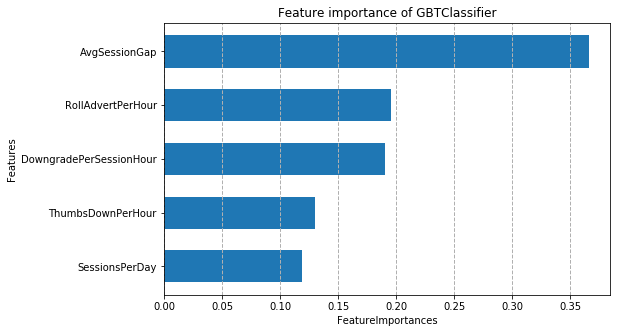

In [132]:
plot_feature_importance(data_gbt, model_gbt, 5, 'Feature importance of GBTClassifier')

### GBT #6 (with Logistic Regression features)

In [ ]:
# Best features chosen for Logistic Regression
data_gbt = data_labels.join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_RollAdvertPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [133]:
scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
classifier = GBTClassifier(featuresCol='features', labelCol = 'label')
model_gbt, metrics_gbt = fit_model(data_gbt, classifier, scaler)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (441 s).


In [134]:
metrics_gbt

,metrics value
F1,0.892143
accuracy,0.880000
weighted precision,0.918000
weighted recall,0.880000
AUC,0.859848


### Cross-Validation

In [135]:
# Best features chosen for Random Forest classifier
data_gbt = data_labels.join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_DowngradePerSessionHour, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [142]:
def fit_model_cv(data, classifier, paramGrid, numFolds=2):
    
    start_time = time.time()
    
    print('Cross validation started. Please wait...')
    
    # Split data into train and test subset
    train, test = split_data(data)
    print('Train|Test data split done.')
    
    # Create pipeline
    scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
    pipeline = create_pipeline(data, classifier, scaler)
    print('Create pipeline done.')
    
    # Create cross validator
    crossValidator = CrossValidator(estimator = pipeline,
                              estimatorParamMaps = paramGrid,
                              evaluator = MulticlassClassificationEvaluator(),
                              numFolds = numFolds)

    # Fit cross validator
    model_cv = crossValidator.fit(train)
    
    duration = time.time() - start_time   
    print(f'Cross validation done ({int(duration)} s).')

    # Get CV scores
    scores_cv = get_cv_scores(model_cv)
    
    return model_cv, scores_cv

def get_cv_scores(model_cv):
    scores = model_cv.avgMetrics
    params = [{p.name: v for p, v in m.items()} for m in model_cv.getEstimatorParamMaps()]
    params_df = pd.DataFrame(params)
    params_df['score'] = scores
    
    return params_df.sort_values(by='score', ascending=False)


In [143]:
# cross validation
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20, 50]) \
    .addGrid(gbt.maxDepth,[2, 5]) \
    .addGrid(gbt.maxBins, [32]) \
    .build()

classifier = GBTClassifier()

model_cv, scores_cv = fit_model_cv(data_gbt, classifier, paramGrid_gbt, 4)
scores_cv

Cross validation started. Please wait...
Train|Test data split done.
Create pipeline done.
Cross validation done (2002 s).


,maxBins,maxDepth,maxIter,score
0,32,2,10,0.863551
1,32,5,10,0.863551
2,32,2,20,0.863551
3,32,5,20,0.863551
4,32,2,50,0.863551
5,32,5,50,0.863551


In [144]:
gbt = model_gbt.stages[2]
print(gbt._java_obj.getMaxIter())
print(gbt._java_obj.getMaxDepth())
print(gbt._java_obj.getMaxBins())

20
5
32


In [147]:
classifier = GBTClassifier(maxIter=10, maxDepth=2, maxBins=32)
model_gbt, metrics_gbt = fit_model(data_gbt, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (394 s).


In [148]:
metrics_gbt

,metrics value
F1,0.871529
accuracy,0.860000
weighted precision,0.890407
weighted recall,0.860000
AUC,0.776515


#### Cross-Validation once again (*4-folded*)

In [149]:
# cross validation
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20, 50]) \
    .addGrid(gbt.maxDepth,[2, 5]) \
    .addGrid(gbt.maxBins, [32]) \
    .build()

classifier = GBTClassifier()

model_cv, scores_cv = fit_model_cv(data_gbt, classifier, paramGrid_gbt, 4)
scores_cv

Cross validation started. Please wait...
Train|Test data split done.
Create pipeline done.
Cross validation done (3506 s).


,maxBins,maxDepth,maxIter,score
0,32,2,10,0.823678
1,32,5,10,0.823678
2,32,2,20,0.823678
3,32,5,20,0.823678
4,32,2,50,0.823678
5,32,5,50,0.823678


In [150]:
data_gbt.printSchema()

root
 |-- label: integer (nullable = true)
 |-- AvgSessionGap: double (nullable = false)
 |-- ThumbsDownPerHour: double (nullable = false)
 |-- RollAdvertPerHour: double (nullable = false)
 |-- DowngradePerSessionHour: double (nullable = false)
 |-- SessionsPerDay: double (nullable = false)
 |-- SessionCount: long (nullable = true)



In [151]:
classifier = GBTClassifier(featuresCol='features', labelCol = 'label')
model_gbt, metrics_gbt = fit_model(data_gbt, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (429 s).


In [152]:
metrics_gbt

,metrics value
F1,0.908235
accuracy,0.900000
weighted precision,0.925203
weighted recall,0.900000
AUC,0.871212


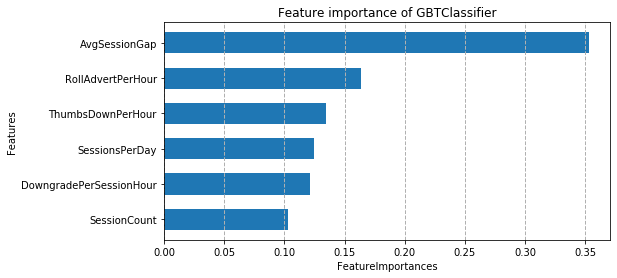

In [153]:
plot_feature_importance(data_gbt, model_gbt, 4, 'Feature importance of GBTClassifier')

In [156]:
classifier = GBTClassifier(featuresCol='features', labelCol = 'label')
model_gbt2, metrics_gbt2 = fit_model(data_gbt, classifier, seed=5)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (401 s).


In [157]:
metrics_gbt2

,metrics value
F1,0.767442
accuracy,0.767442
weighted precision,0.767442
weighted recall,0.767442
AUC,0.616071


In [163]:
# Obtain predictions on the test set
train, test = split_data(data_gbt)
results_rf = model_gbt2.transform(test)
results_rf.select(['label','rawPrediction','probability','prediction']).show(5)
#results_rf.show()

+-----+--------------------+--------------------+----------+
|label|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+----------+
|    0|[1.39240508665227...|[0.94184945373804...|       0.0|
|    0|[1.55991200855802...|[0.95770310003996...|       0.0|
|    0|[1.52648321741862...|[0.95491042333640...|       0.0|
|    0|[1.53172637700482...|[0.95535977990903...|       0.0|
|    0|[1.55536796166031...|[0.95733342552610...|       0.0|
+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [164]:
results_rf.select(['label','rawPrediction','probability','prediction']).show(50)

+-----+--------------------+--------------------+----------+
|label|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+----------+
|    0|[1.39240508665227...|[0.94184945373804...|       0.0|
|    0|[1.55991200855802...|[0.95770310003996...|       0.0|
|    0|[1.52648321741862...|[0.95491042333640...|       0.0|
|    0|[1.53172637700482...|[0.95535977990903...|       0.0|
|    0|[1.55536796166031...|[0.95733342552610...|       0.0|
|    0|[-1.1060375903192...|[0.09867136254798...|       1.0|
|    0|[1.57277777056924...|[0.95873324011858...|       0.0|
|    0|[0.89917445442027...|[0.85794782998680...|       0.0|
|    0|[1.55538980452501...|[0.95733520988378...|       0.0|
|    0|[1.53123058402248...|[0.95531747217584...|       0.0|
|    0|[1.55448443616433...|[0.95726118996058...|       0.0|
|    1|[-1.2388238579518...|[0.07744008970236...|       1.0|
|    0|[1.57396084818257...|[0.95882675269946...|       0.0|
|    0|[1.57757719696333

In [166]:
results_rf.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|    6|
|    0|   44|
+-----+-----+



In [167]:
prediction_gbt = model_gbt.transform(test)
prediction_gbt.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|    6|
|    0|   44|
+-----+-----+



#### Model data (*seed=5*)

In [170]:
# Best features chosen for Random Forest classifier
data_gbt_5 = data_labels.join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_ThumbsUpPerDay, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_NonSongCount, 'userId', 'outer') \
    .join(f_DowngradePerSessionHour, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_SettingsPerSessionHour, 'userId', 'outer') \
    .join(f_SaveSettingsPerSessionHour, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_UpgradePerHour, 'userId', 'outer') \
    .join(f_LogCount, 'userId', 'outer') \
    .join(f_AddFriendPerDay, 'userId', 'outer') \
    .join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_AboutCount, 'userId', 'outer') \
    .join(f_RollAdvertPerDay, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [171]:
classifier = GBTClassifier(featuresCol='features', labelCol = 'label')
model_gbt_5, metrics_gbt_5 = fit_model(data_gbt_5, classifier, seed=5)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (838 s).


In [172]:
metrics_gbt_5

,metrics value
F1,0.821771
accuracy,0.837209
weighted precision,0.818482
weighted recall,0.837209
AUC,0.658929


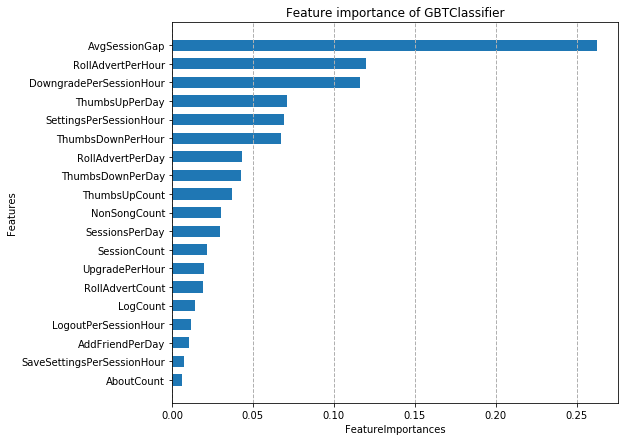

In [174]:
plot_feature_importance(data_gbt_5, model_gbt_5, 7, 'Feature importance of GBTClassifier')

In [176]:
classifier = GBTClassifier(featuresCol='features', labelCol = 'label')
model_gbt, metrics_gbt = fit_model(data_gbt_5, classifier, seed=0)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (848 s).


In [177]:
metrics_gbt

,metrics value
F1,0.896016
accuracy,0.900000
weighted precision,0.893333
weighted recall,0.900000
AUC,0.727273


#### Check Logistic Regression with seed=5

In [186]:
# Best features chosen for Logistic Regression
data_lr = data_labels.join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_RollAdvertPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

classifier = LogisticRegression(featuresCol="features", labelCol = "label")
model_lr_5, metrics_lr_5 = fit_model(data_lr_5, classifier, seed=5)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.


KeyboardInterrupt: 

In [182]:
metrics_lr_5

,metrics value
F1,0.860465
accuracy,0.860465
weighted precision,0.860465
weighted recall,0.860465
AUC,0.769643


In [ ]:
# elasticNetParam=0.0, maxIter=10, regParam=0.1

In [184]:
classifier = LogisticRegression(featuresCol='features', labelCol='label', \
                                elasticNetParam=0.0, maxIter=10, regParam=0.1)
model_lr_5, metrics_lr_5 = fit_model(data_lr, classifier, seed=5)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (387 s).


In [185]:
metrics_lr_5

,metrics value
F1,0.861170
accuracy,0.883721
weighted precision,0.898256
weighted recall,0.883721
AUC,0.687500


### Seed 99 - Logistic Regression

In [187]:
classifier = LogisticRegression(featuresCol='features', labelCol='label', \
                                elasticNetParam=0.0, maxIter=10, regParam=0.1)
model_lr_47, metrics_lr_47 = fit_model(data_lr, classifier, seed=47)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (374 s).


In [ ]:
metrics_lr_47

In [188]:
classifier = LogisticRegression(featuresCol='features', labelCol='label', \
                                elasticNetParam=0.0, maxIter=10, regParam=0.1)
model_lr_99, metrics_lr_99 = fit_model(data_lr, classifier, seed=99)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (385 s).


In [ ]:
metrics_lr_99

## LinearSVC

In [ ]:
#SVM
svm = LinearSVC(maxIter=10, regParam=0.1)
svm_model=svm.fit(train)
svm_preds=svm_model.transform(validation)
custom_evaluation(svm_preds, 'Support Vector Machine')

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.